<a href="https://colab.research.google.com/github/1minute99/Brain-Tumor-Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification with MRI Images

### Objective
Building a Machine Learning Model that can classify brain tumor with MRI images.

### About the data
- The images are separated by astrocytoma, carcinoma, ependymoma, ganglioglioma, germinoma, glioblastoma, granuloma, medulloblastoma, meningioma, neurocytoma, oligodendroglioma, papilloma, schwannoma and tuberculoma.
- A private collection of T1, contrast-enhanced T1, and T2 magnetic resonance images separated by brain tumor type.
- Images without any type of marking or patient identification, interpreted by radiologists and provided for study purposes.

### Data Source
- The dataset is from kaggle Brain Tumor MRI Images 44 Classes dataset.
- https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c/data

### Data Preprocessing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings
import scipy
import random
import os

warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
plt.rcParams["figure.dpi"] = 100

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/brain-tumor-mri-images-44c")

print("Path to dataset files:", path)

100%|██████████| 188M/188M [00:09<00:00, 20.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fernando2rad/brain-tumor-mri-images-44c/versions/1


In [ ]:
dir = path

labels = []
image_path = []
for folder in os.listdir(dir):
    for file in os.listdir(dir + '/' + folder):
        labels.append(folder)
        image_path.append(dir + '/' + folder + '/' + file)

df = pd.DataFrame(labels, columns=["Label"])
df["Image Path"] = image_path

df

,Label,Image Path
0,Ganglioglioma T2,/root/.cache/kagglehub/datasets/fernando2rad/b...
1,Ganglioglioma T2,/root/.cache/kagglehub/datasets/fernando2rad/b...
2,Ganglioglioma T2,/root/.cache/kagglehub/datasets/fernando2rad/b...
3,Ganglioglioma T2,/root/.cache/kagglehub/datasets/fernando2rad/b...
4,Ganglioglioma T2,/root/.cache/kagglehub/datasets/fernando2rad/b...
...,...,...
4474,Carcinoma T1,/root/.cache/kagglehub/datasets/fernando2rad/b...
4475,Carcinoma T1,/root/.cache/kagglehub/datasets/fernando2rad/b...
4476,Carcinoma T1,/root/.cache/kagglehub/datasets/fernando2rad/b...
4477,Carcinoma T1,/root/.cache/kagglehub/datasets/fernando2rad/b...


In [ ]:
df["Label"] = df["Label"].str.replace(" T2", "", regex=False)
df["Label"] = df["Label"].str.replace(" T1C+", "", regex=False)
df["Label"] = df["Label"].str.replace(" T1", "", regex=False)
df["Label"] = df["Label"].str.replace("_", "", regex=False)
df["Label"] = df["Label"].str.replace("NORMAL", "Normal", regex=False)

for x in df["Label"].unique():
    print(x)

Ganglioglioma
Astrocitoma
Neurocitoma
Granuloma
Ependimoma
Normal
Tuberculoma
Carcinoma
Germinoma
Meningioma
Oligodendroglioma
Papiloma
Glioblastoma
Schwannoma
Meduloblastoma


### Exploratory Data Analysis (EDA)

##### Image by Label

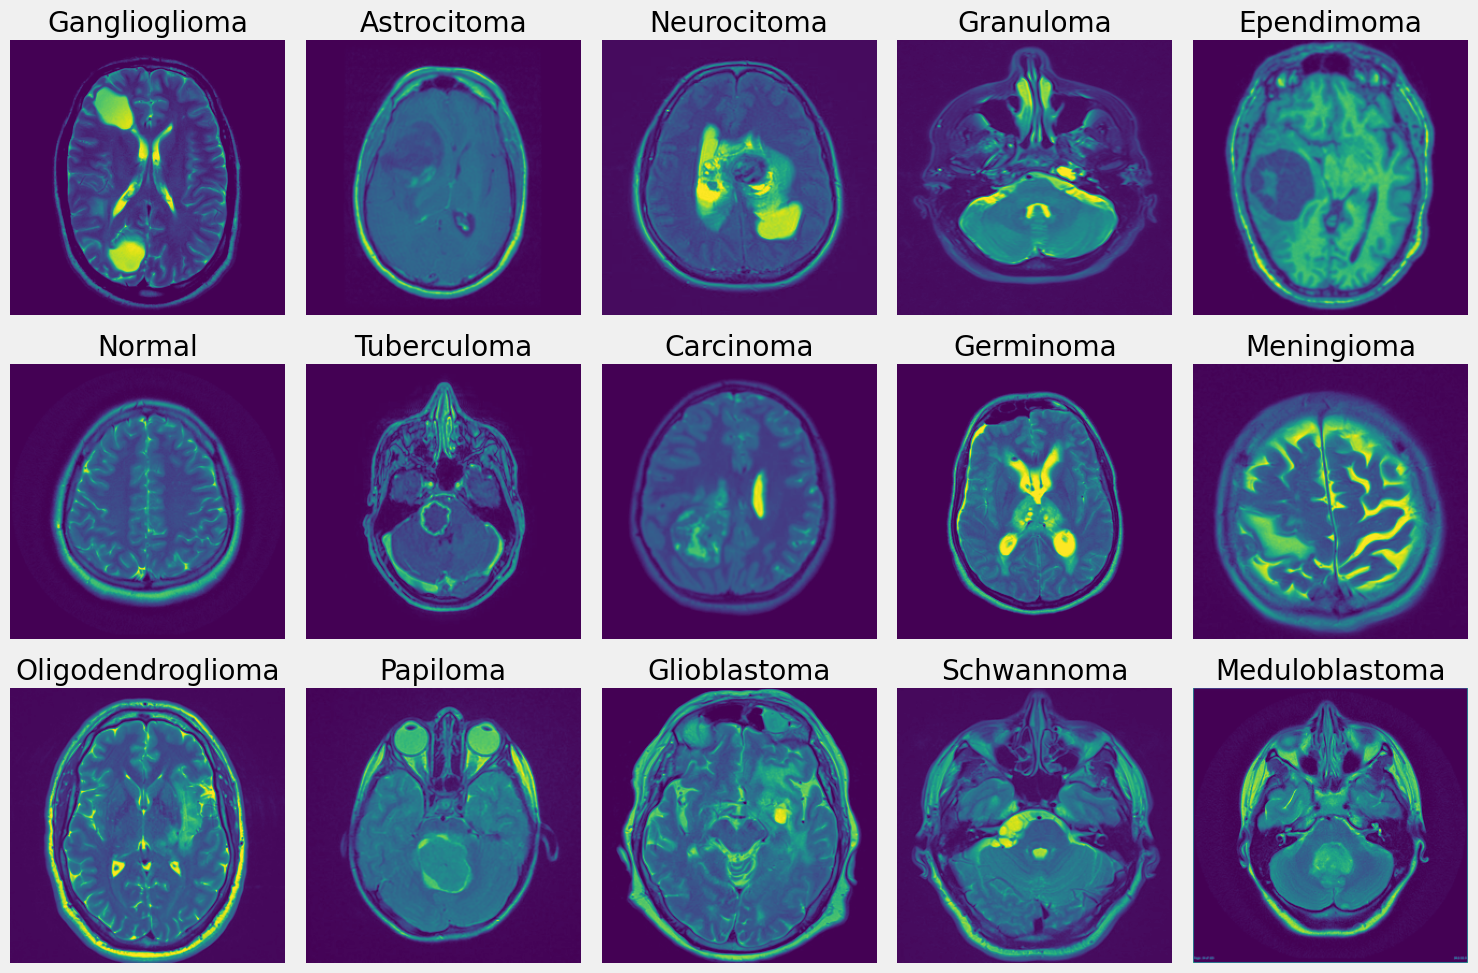

In [ ]:
from PIL import Image

labels = [x for x in df["Label"].unique()]

plt.figure(figsize=(15,10))
for i in range(len(labels)):
    img = Image.open(df.loc[df["Label"] == labels[i], "Image Path"].iloc[0])
    img = img.resize((256, 256))
    img = img.convert("L")

    plt.subplot(3,5,i+1)
    plt.title(labels[i])
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

##### Count plot by Label

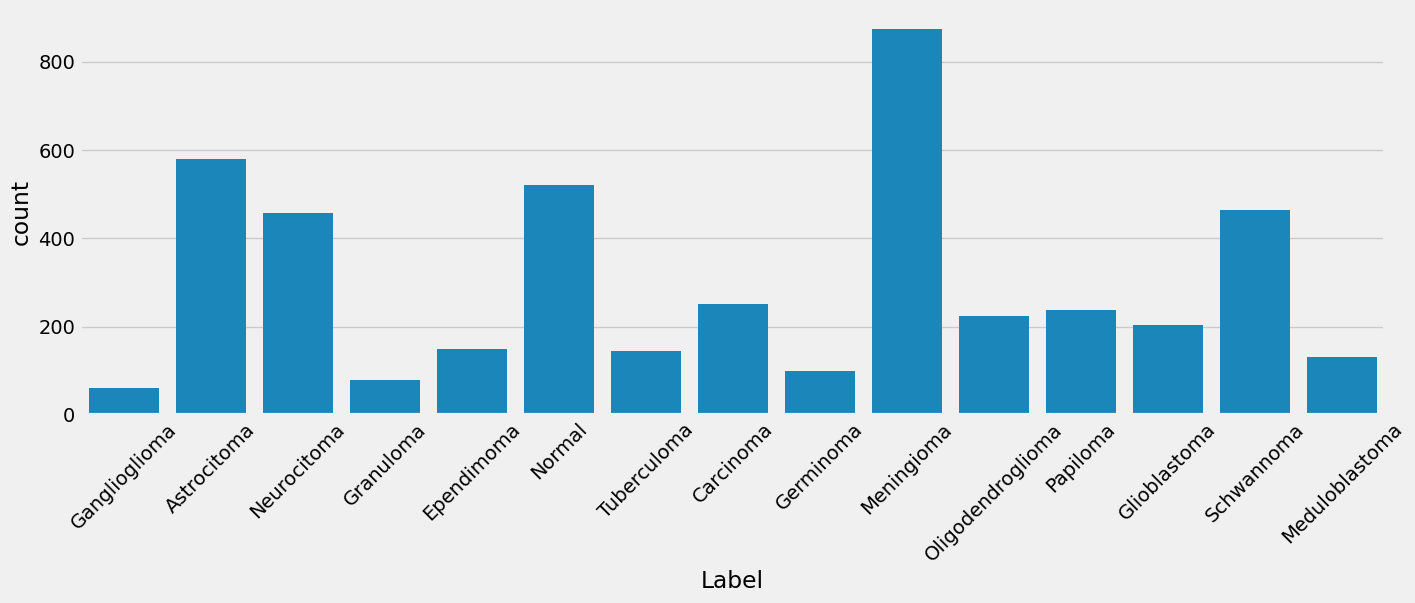

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,5))
sns.countplot(data=df, x='Label')
plt.xticks(rotation = 45)
plt.show()

It is evident that the categories are not evenly distributed. To prevent bias and poor generalization, I will later use weight control.

##### Count plot for Train / Validation / Test Splitted data

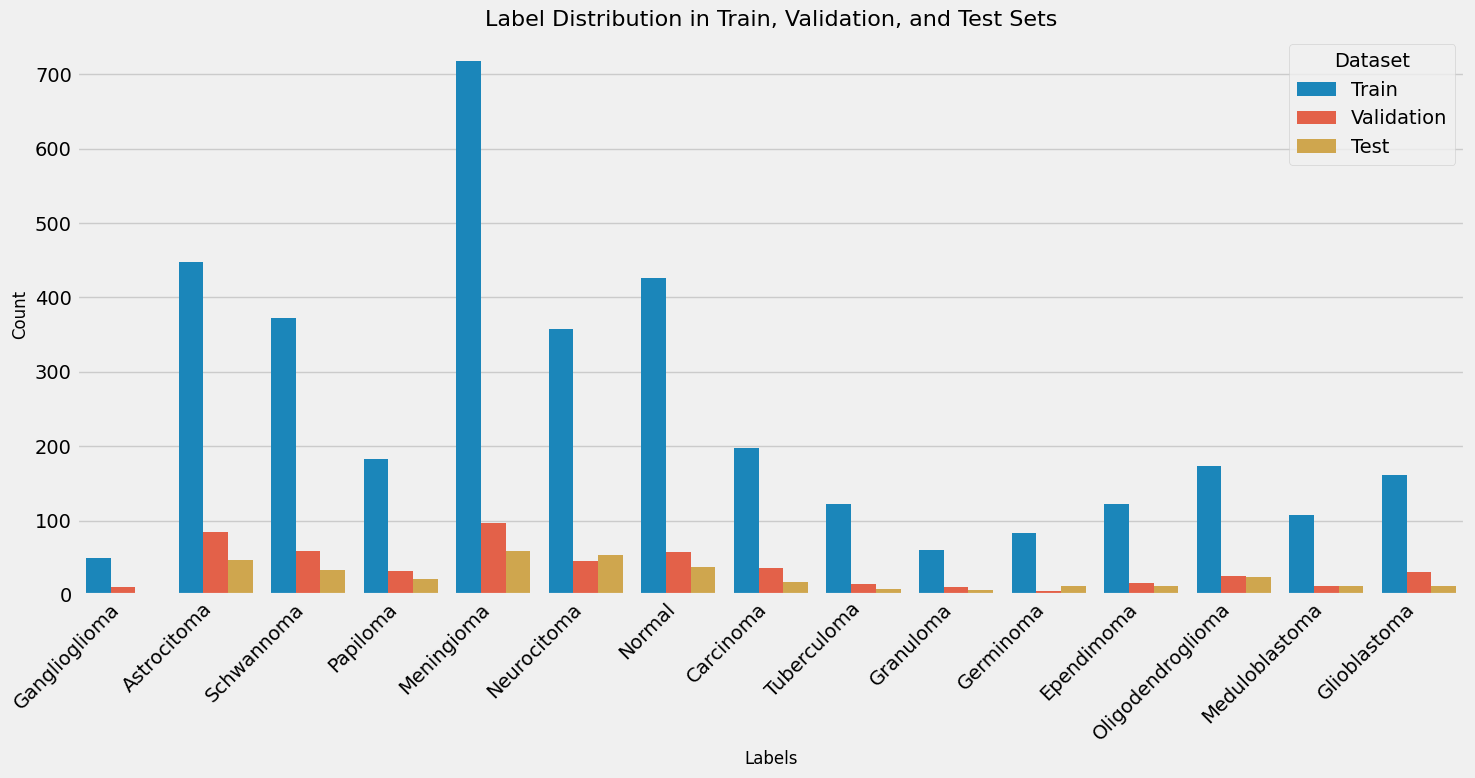

In [ ]:
from sklearn.model_selection import train_test_split

train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 42)

train_df['Dataset'] = 'Train'
valid_df['Dataset'] = 'Validation'
test_df['Dataset'] = 'Test'

combined_df = pd.concat([train_df, valid_df, test_df])

plt.figure(figsize=(15, 8))
sns.countplot(data=combined_df, x='Label', hue='Dataset')

plt.title('Label Distribution in Train, Validation, and Test Sets', fontsize=16)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

train_df = train_df.drop('Dataset', axis=1)
valid_df = valid_df.drop('Dataset', axis=1)
test_df = test_df.drop('Dataset', axis=1)

In [ ]:
# GPU check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Unsupervised ML: K means clustering with PCA

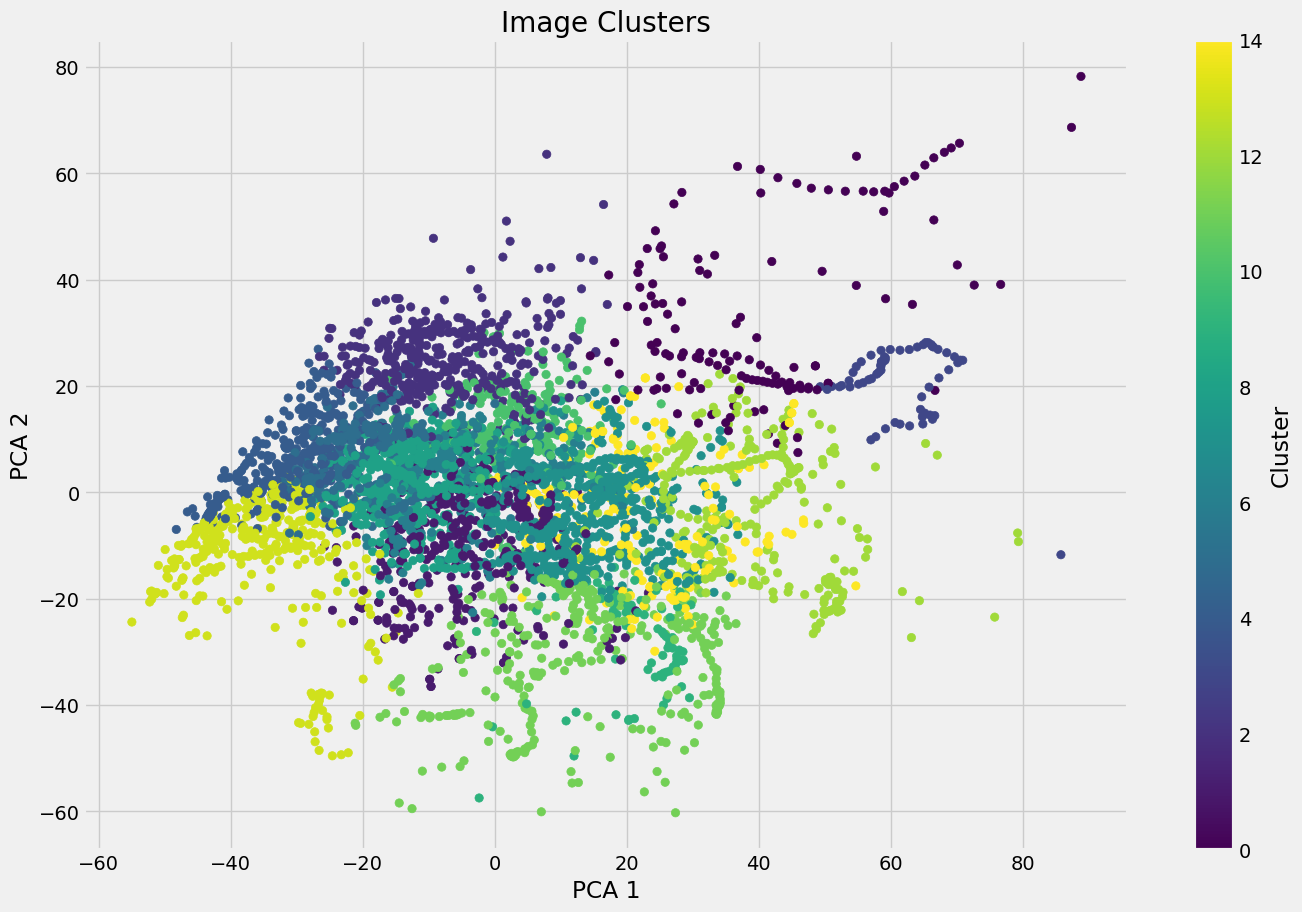

Silhouette Score: 0.05669911950826645


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        images.append(img_array.flatten())
    return np.array(images)

image_data = load_images(df['Image Path'])

pca = PCA(n_components=50)
reduced_data = pca.fit_transform(image_data)

kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(reduced_data)

df['Cluster'] = kmeans.labels_

pca_2d = PCA(n_components=2)
data_2d = pca_2d.fit_transform(reduced_data)

plt.figure(figsize=(15,10))
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('Image Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

silhouette_avg = silhouette_score(reduced_data, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")


Based on the graph and Silhouette Score, it is evident that K-means clustering with PCA does not yield significant or meaningful categorization for this dataset. It is quite understandable the performance is poor as the dataset consists of complex images.

### Supervised ML: Covolutional Neural Network

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Normalization needed
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

image_size = (256, 256)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='Image Path', y_col='Label',
    target_size=image_size, batch_size=32, class_mode='categorical', color_mode = 'rgb', shuffle = True
)

val_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col='Image Path', y_col='Label',
    target_size=image_size, batch_size=32, class_mode='categorical', color_mode = 'rgb', shuffle = True
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='Image Path', y_col='Label',
    target_size=image_size, batch_size=32, class_mode='categorical', color_mode = 'rgb', shuffle=False
)


Found 3582 validated image filenames belonging to 15 classes.
Found 537 validated image filenames belonging to 15 classes.
Found 359 validated image filenames belonging to 15 classes.


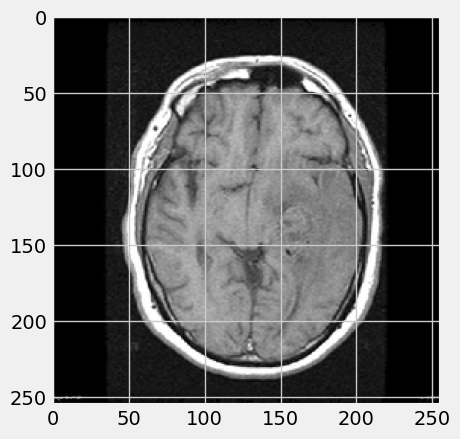

In [ ]:
images, labels = next(train_gen)
plt.imshow(images[0])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.initializers import HeNormal

# CNN designing
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer=HeNormal(), input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer=HeNormal()),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

model.summary()

# Learning Rate Adjustment
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      62,980,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,003,983 (240.34 MB)

 Trainable params: 63,003,791 (240.34 MB)

 Non-trainable params: 192 (768.00 B)

- Conv2d layer: Applies a convolution operation to extract spatial features from the input image.
- BatchNormalization: Normalizes the activations of the previous layer to stabilize training and improve convergence.
- MaxPooling2D Layer: Reduces the spatial dimensions of the feature maps, keeping only the most prominent features.
- Flatten Layer: Converts the 3D feature maps (height, width, depth) into a 1D vector to feed into fully connected layers for classification.
- Dense Layer: A fully connected layer with 256 neurons that learns to combine features from the previous layers to predict class probabilities.
- Dropout Layer: Reduces overfitting by randomly deactivating some neurons during training.
- Dense Layer: The output layer for classification, with 15 neurons corresponding to 15 classes.

In [ ]:
# Callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Label']),
    y=train_df['Label']
)

class_weights = dict(enumerate(class_weights))

# Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 171ms/step - accuracy: 0.1769 - loss: 7.7937 - val_accuracy: 0.1695 - val_loss: 2.5222 - learning_rate: 1.0000e-04
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.2906 - loss: 2.1487 - val_accuracy: 0.1955 - val_loss: 2.6467 - learning_rate: 1.0000e-04
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.3141 - loss: 2.1480 - val_accuracy: 0.3073 - val_loss: 2.1437 - learning_rate: 1.0000e-04
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.4165 - loss: 1.8086 - val_accuracy: 0.4153 - val_loss: 1.9066 - learning_rate: 1.0000e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.4336 - loss: 1.7516 - val_accuracy: 0.4935 - val_loss: 1.7166 - learning_rate: 1.0000e-04
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - accuracy: 0.4632 - loss: 1.5757 - val_accuracy: 0.5773 - val_loss: 1.3609 - learning_rate: 1.0000e-04
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/st

Weight control and hyperparameter tuning was performed.

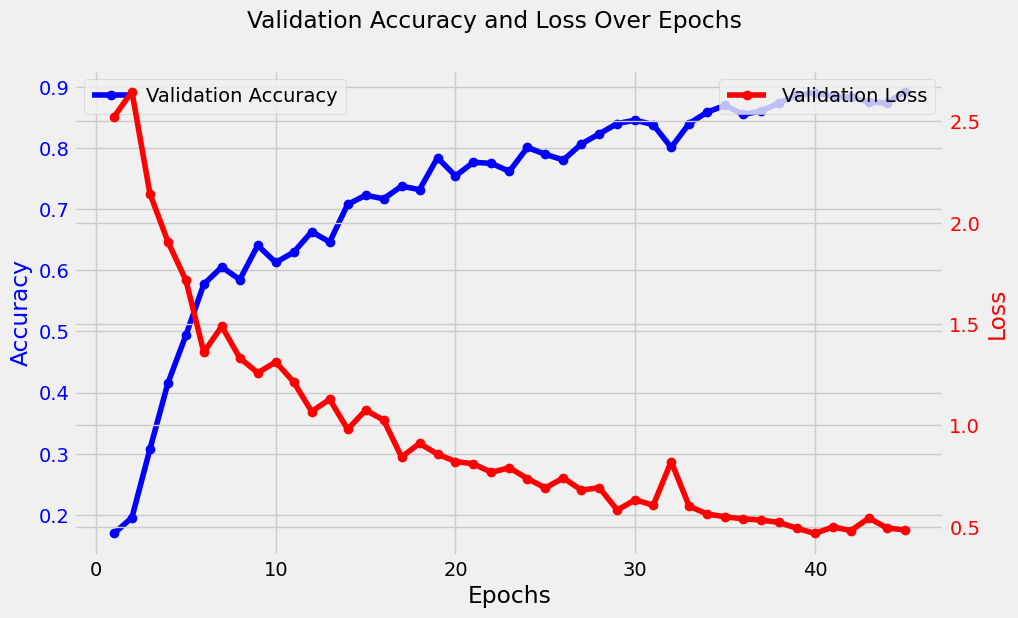

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
accuracy = history.history['val_accuracy']
loss = history.history['val_loss']

fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(epochs, accuracy, label='Validation Accuracy', color='darkblue', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2 = ax1.twinx()
ax2.plot(epochs, loss, label='Validation Loss', color='orange', marker='o')
ax2.set_ylabel('Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

fig.suptitle('Validation Accuracy and Loss Over Epochs')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()

It is evident that the accuracy and loss curves are following an ideal pattern, indicating that the model is being trained effectively.

In [ ]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9046 - loss: 0.4721
Validation Accuracy: 89.01%
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.8634 - loss: 0.4378
Test Accuracy: 86.07%


The model shows good performance with an accuracy of 87.07% on Test data.

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step


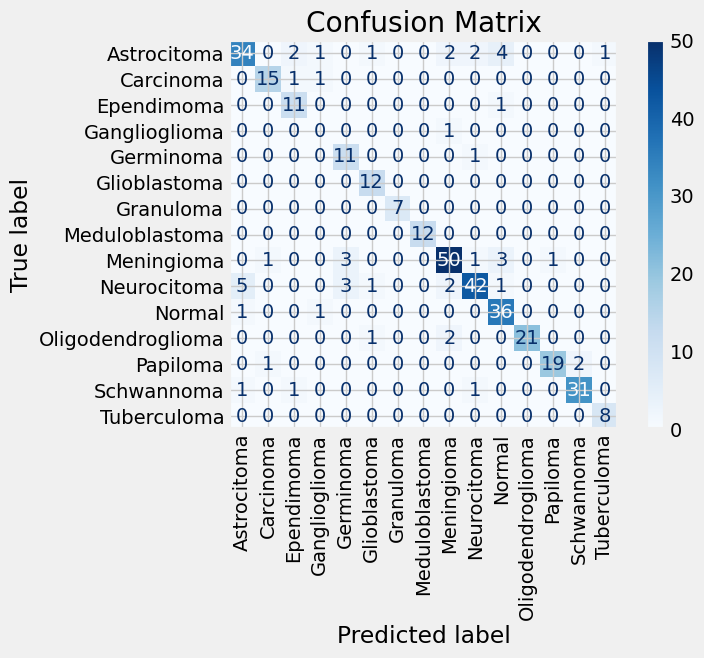

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())


cm = confusion_matrix(y_true, y_pred)

# Visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

While the model performs well in most cases, it exhibits the highest degree of confusion between Neurocitoma and Astrocitoma.

### Supervised ML: Transfer Learning (EfficientNetB5)

Transfer learning reuses pre-trained models for new tasks, reducing training time and data needs. EfficientNet is a family of convolutional neural networks (CNNs) that achieves better performance with fewer parameters by optimizing width, depth, and resolution scaling systematically.

In [ ]:
# EfficientNetB5 -> Normalization is not needed
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

image_size = (300, 300)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='Image Path', y_col='Label',
    target_size=image_size, batch_size=16, class_mode='categorical', color_mode = 'rgb', shuffle = True
)

val_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col='Image Path', y_col='Label',
    target_size=image_size, batch_size=16, class_mode='categorical', color_mode = 'rgb', shuffle = True
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='Image Path', y_col='Label',
    target_size=image_size, batch_size=16, class_mode='categorical', color_mode = 'rgb', shuffle=False
)

Found 3582 validated image filenames belonging to 15 classes.
Found 537 validated image filenames belonging to 15 classes.
Found 359 validated image filenames belonging to 15 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB5

# Pre-trained EfficientNetB5
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(300, 300, 3), pooling= 'max', classes=15, classifier_activation="softmax")

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

model.summary()

# Learning Rate Adjustment
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)          │ (None, 2048)                │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,041,926 (110.79 MB)

 Trainable params: 28,869,183 (110.13 MB)

 Non-trainable params: 172,743 (674.78 KB)

In [ ]:
# Callback setting
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Label']),
    y=train_df['Label']
)

class_weights = dict(enumerate(class_weights))

# Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 321s 683ms/step - accuracy: 0.1449 - loss: 5.2715 - val_accuracy: 0.1937 - val_loss: 2.5267 - learning_rate: 1.0000e-04
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.3227 - loss: 1.8816 - val_accuracy: 0.3594 - val_loss: 1.9484 - learning_rate: 1.0000e-04
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.5167 - loss: 1.2873 - val_accuracy: 0.5233 - val_loss: 1.5587 - learning_rate: 1.0000e-04
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.6564 - loss: 0.8222 - val_accuracy: 0.7709 - val_loss: 0.6885 - learning_rate: 1.0000e-04
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - accuracy: 0.7463 - loss: 0.5814 - val_accuracy: 0.8603 - val_loss: 0.4493 - learning_rate: 1.0000e-04
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.8187 - loss: 0.4083 - val_accuracy: 0.8529 - val_loss: 0.4373 - learning_rate: 1.0000e-04
Epoch 7/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 25s 1

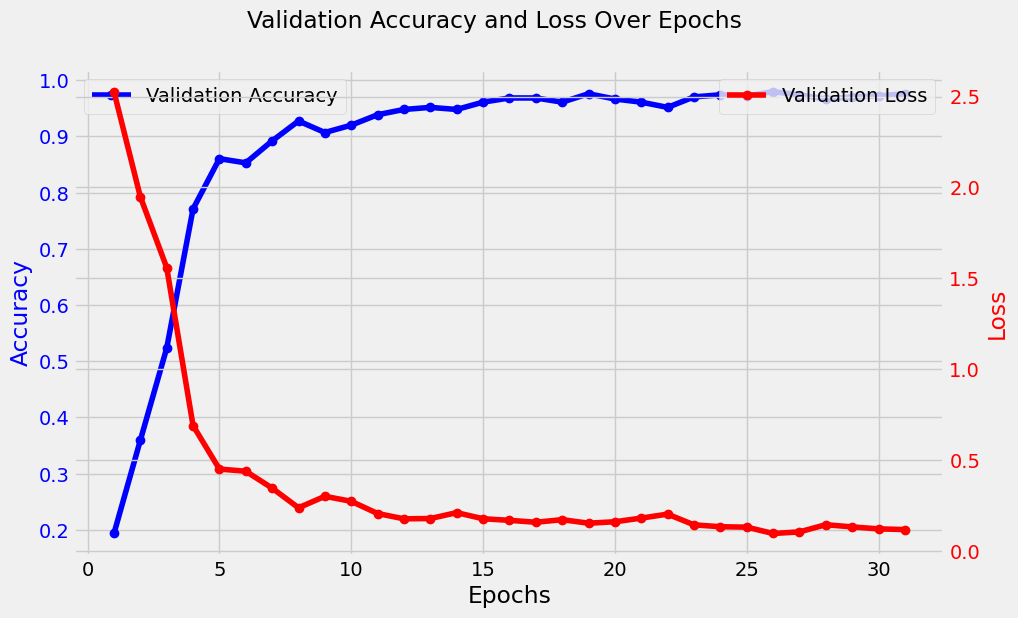

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)
accuracy = history.history['val_accuracy']
loss = history.history['val_loss']

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(epochs, accuracy, label='Validation Accuracy', color='blue', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(epochs, loss, label='Validation Loss', color='red', marker='o')
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Validation Accuracy and Loss Over Epochs')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()

Similar to the previous model, the accuracy and loss functions follow ideal path. It achieved higher accuracy faster than the previous model.

In [ ]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9792 - loss: 0.1197
Validation Accuracy: 97.95%
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - accuracy: 0.9691 - loss: 0.1167
Test Accuracy: 97.77%


The test accuracy is 97.97%, which is nearly perfect.

23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 587ms/step


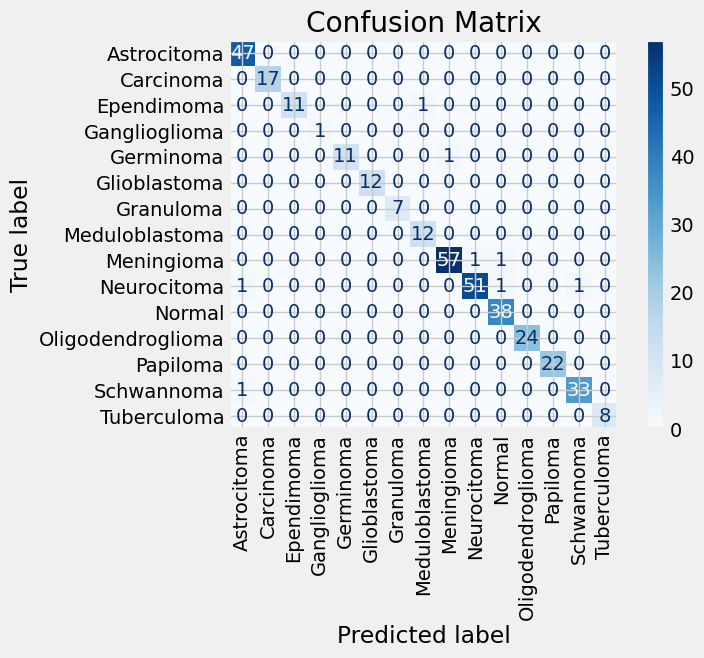

In [ ]:
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())  # Class names

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

The absence of any category that the model misclassified more than once indicates that it is well-aligned with the data and performs effectively across the board.

### Conclusion
The model built using transfer learning shows almost excellent accuracy with 97.77% and the CNN model also shows good accuracy while the model using k means clustering with PCA does not show meaningful performance.